In [1]:
from functools import partial
import logging
from collections import OrderedDict

import numpy as np
from osgeo import gdal
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import proxmin
from proxmin import nmf
import dc

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.DEBUG)

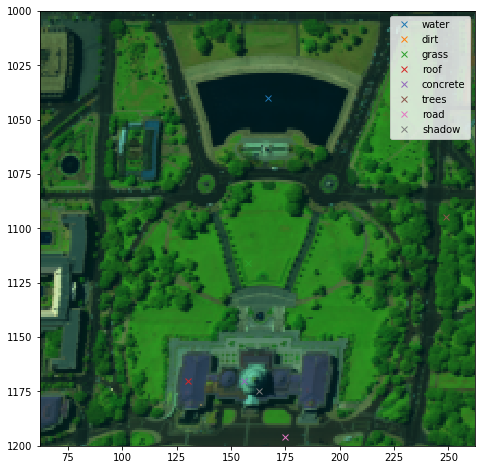

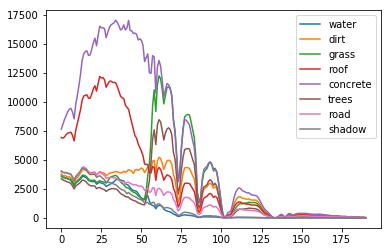

In [57]:
ds = gdal.Open('/Users/fred/Downloads/Hyperspectral_Project/dc.tif')
data_shape = ds.GetRasterBand(1).ReadAsArray().shape

# only use a subset of the image
shape = (ds.RasterCount, data_shape[0]*data_shape[1])
points = dc.ref_points

# Get hyperspectral data
data = np.zeros(shape)
for bidx in range(shape[0]):
    band = ds.GetRasterBand(bidx + 1).ReadAsArray()
    data[bidx] = band.flatten()
dc.plot_color_img(data, data_shape, figsize=(8,8), show=False);

points = OrderedDict([
    ('water', (167, 1040)),
    ('dirt', (132, 272)),
    ('grass', (158, 1116)),
    #('grass', (166, 1105)),
    ('roof', (130, 1170)),
    ('concrete', (156, 1170)),
    #('trees', (249, 1123)),
    ('trees', (249, 1095)),
    ('road', (175, 1196)),
    #('road', (138, 1086)),
    #('shadow', (175, 465))
    #('shadow', (70, 1160))
    ("shadow", (163, 1175))
])

spectra = OrderedDict()
for obj, pt in points.items():
    plt.plot(pt[0], pt[1],'x', label=obj)
    spectra[obj] = dc.get_point_spec(pt[0], pt[1], data, data_shape)
plt.legend()
plt.xlim([62,262])
plt.ylim([1200,1000])
plt.show()

for obj, pt in points.items():
    plt.plot(spectra[obj], label=obj)
plt.legend()
plt.show()

# Get wavelengths used in hyperspectral data
wavelength_data = np.recfromcsv('/Users/fred/Downloads/Hyperspectral_Project/wavelengths.txt', delimiter=" ")
wavelength = wavelength_data["wavelength"]
idx = wavelength_data["idx"]

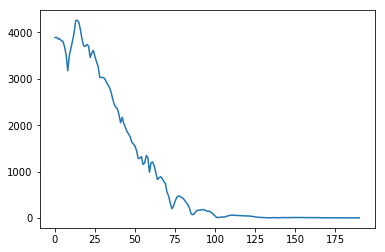

In [86]:
plt.plot(data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,1175, 163])

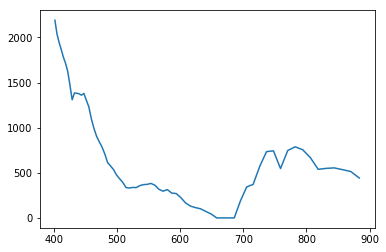

In [84]:
plt.plot(wavelength[:70], bkg_model[:70])

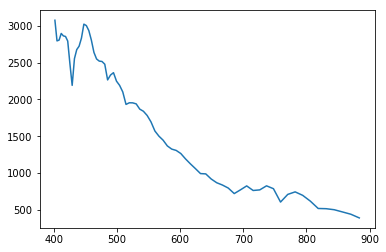

In [83]:
plt.plot(wavelength[:70], np.min(subset, axis=1)[:70])

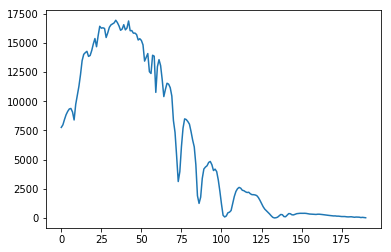

In [77]:
plt.plot(data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,1170, 156])
plt.show()
#plt.plot(np.min(subset, axis=1))

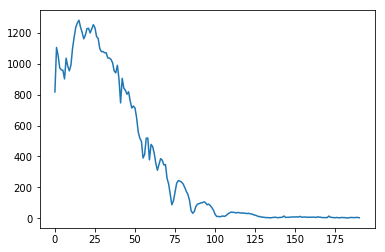

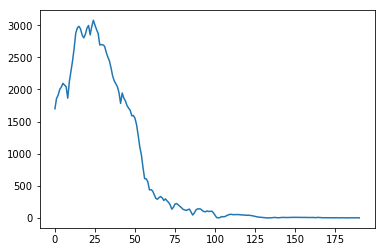

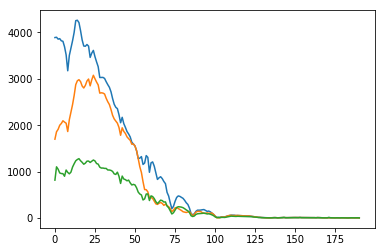

In [76]:
plt.plot(data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,1175, 163]-np.min(subset, axis=1))
plt.show()
plt.plot(data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,1175, 163]-bkg_model)
plt.show()
plt.plot(data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,1175, 163])
plt.plot(data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,1175, 163]-bkg_model)
plt.plot(data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,1175, 163]-np.min(subset, axis=1))
plt.show()


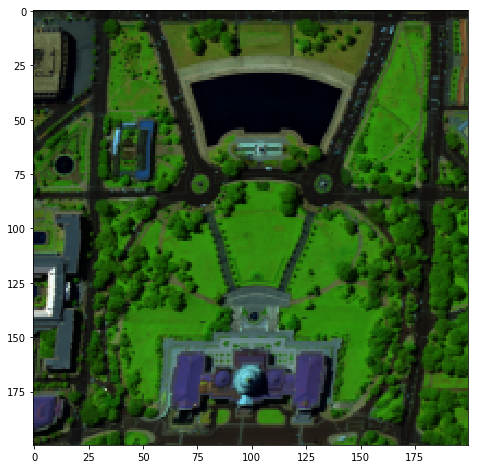

In [3]:
# only use a subset of the image
xmin = 62
xmax = 262
ymin = 1000
ymax = 1200
img_shape = (ymax-ymin, xmax-xmin)
subset = data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,ymin:ymax, xmin:xmax]
subset = subset.reshape(data.shape[0], img_shape[0]*img_shape[1])
dc.plot_color_img(subset, img_shape);

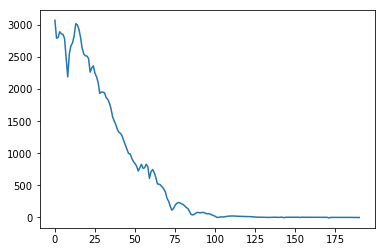

In [13]:
def init_nmf(data, img_shape, points, spec, use_bkg=False):
    """Initialize A0 and S0 using the reference points
    """
    K = len(points)
    # Optionally add an extra component for the background
    if use_bkg:
        K += 1
    A0 = np.zeros((data.shape[0], K))
    S0 = np.zeros((K, img_shape[0]*img_shape[1]))

    # Create A0 and S0 from the spectral data at certain pixels
    for idx, (obj,(x,y)) in enumerate(points.items()):
        A0[:, idx] = spec[obj]
        S0[idx, y*img_shape[1]+x] = np.max(A0[:,idx])

    # Optionally initialize the background
    if use_bkg:
        A0[:,-1] = np.min(data, axis=1)
        S0[-1,:] = np.max(A0[:,-1])
    plt.plot(A0[:, -1])
    plt.show()
    
    norm = np.sum(A0, axis=0)
    A0 = A0/norm
    return A0, S0

points = dc.ref_points
if "shadow" in points:
    del points["shadow"]
A0,S0 = init_nmf(subset, img_shape, points, spectra, use_bkg=True)

points = dc.ref_points

prox_A = proxmin.operators.prox_unity_plus

In [14]:
import scipy.sparse
def prox_bkg(X, step, bidx=-1):
    """Use a constant background
    """
    X[bidx] = np.mean(X[bidx])
    return X

def prox_bkg_plus(X, step, bidx=-1):
    X = prox_bkg(X, step, bidx)
    X = proxmin.operators.prox_plus(X, step)
    return X

prox_S = partial(prox_bkg_plus, bidx=-1)

Ls = [[None], [scipy.sparse.identity(A0.shape[1])]]
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]

In [15]:
A, S, hist = nmf.nmf(subset, A0, S0, prox_A, prox_S, max_iter=1000, traceback=True)
#A, S, hist = nmf.nmf(subset, A0, S0, prox_A, max_iter=1000, )

INFO:proxmin.algorithms:Completed 1001 iterations


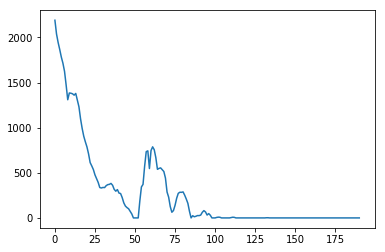

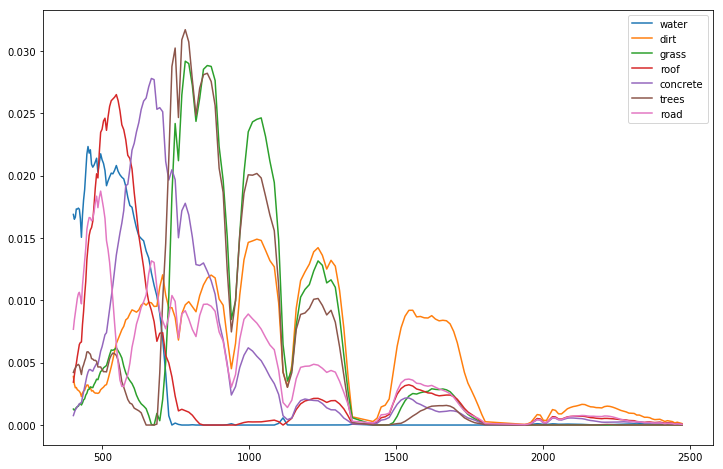

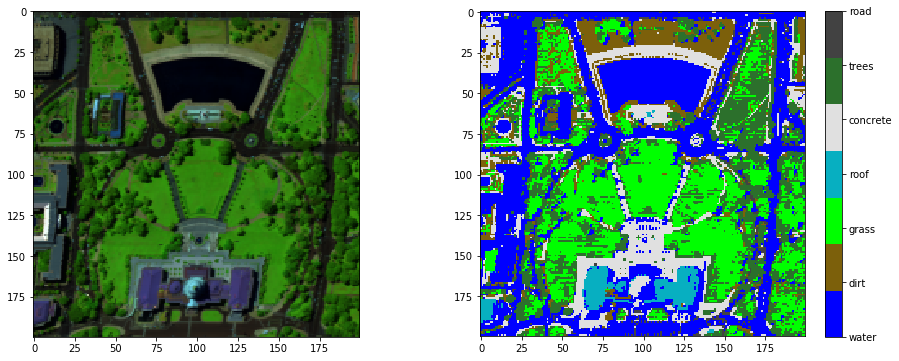

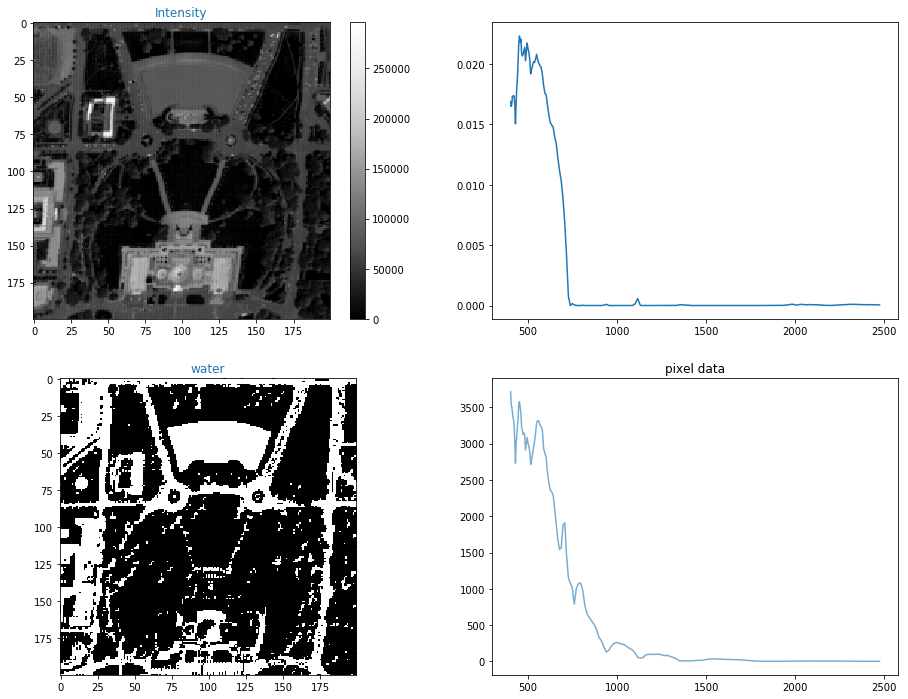

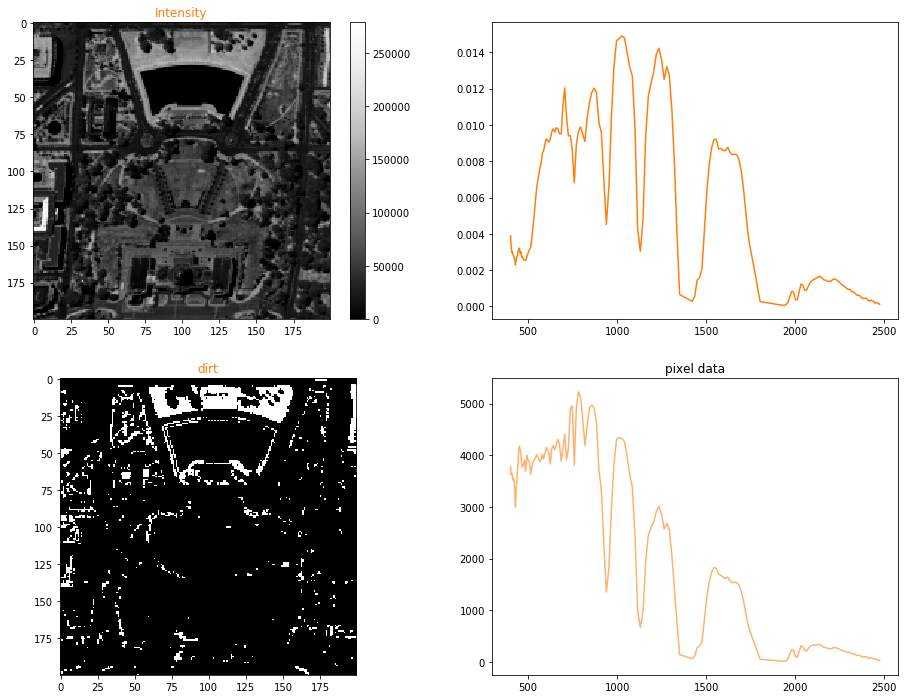

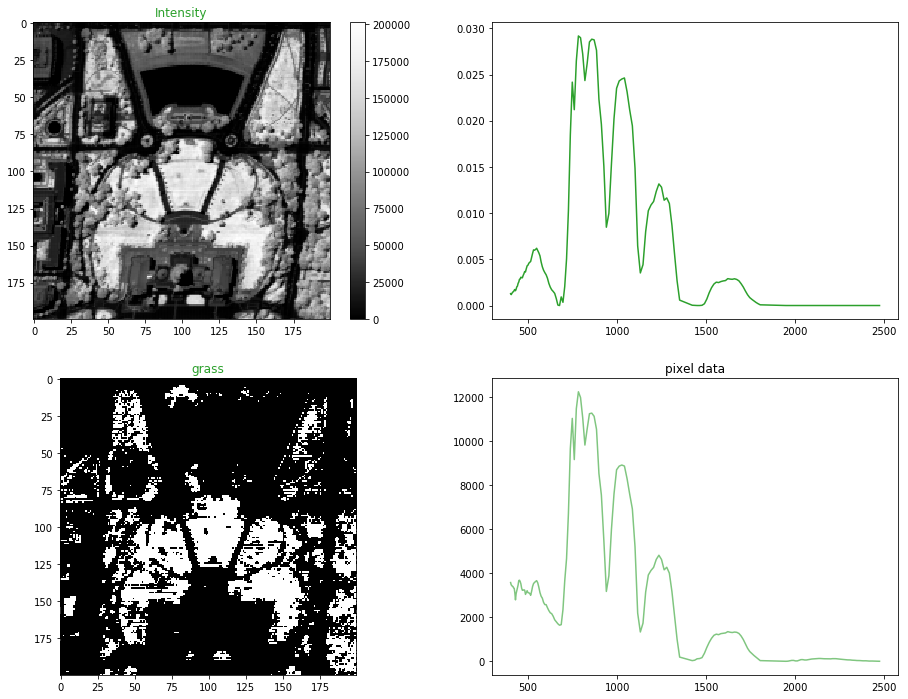

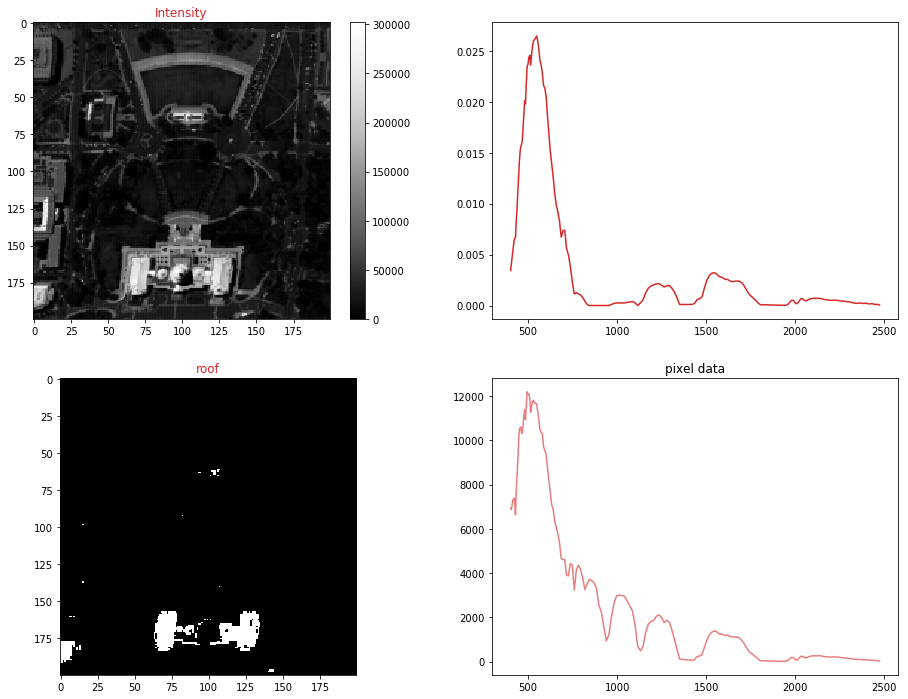

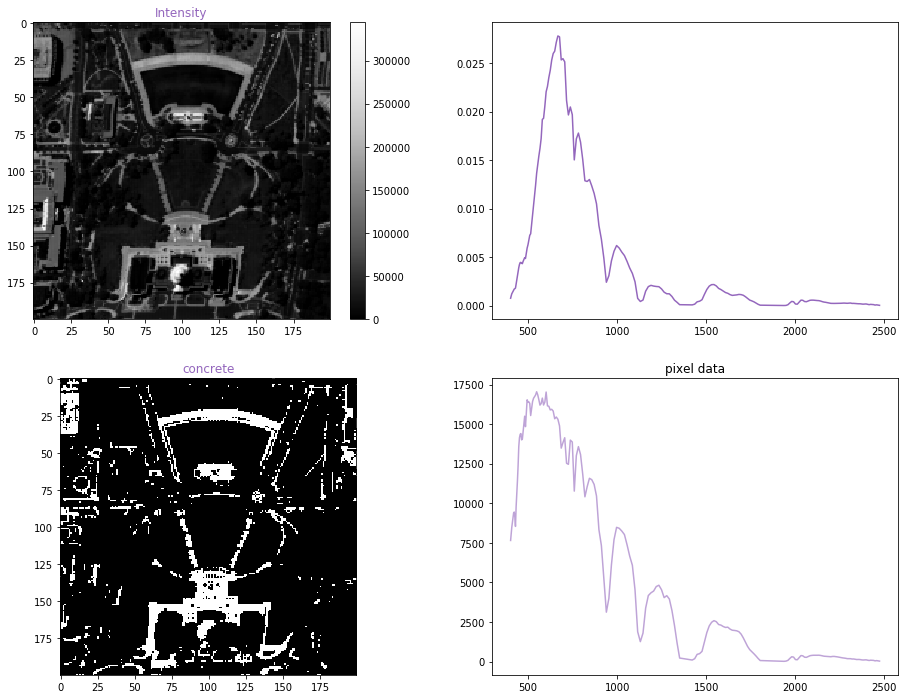

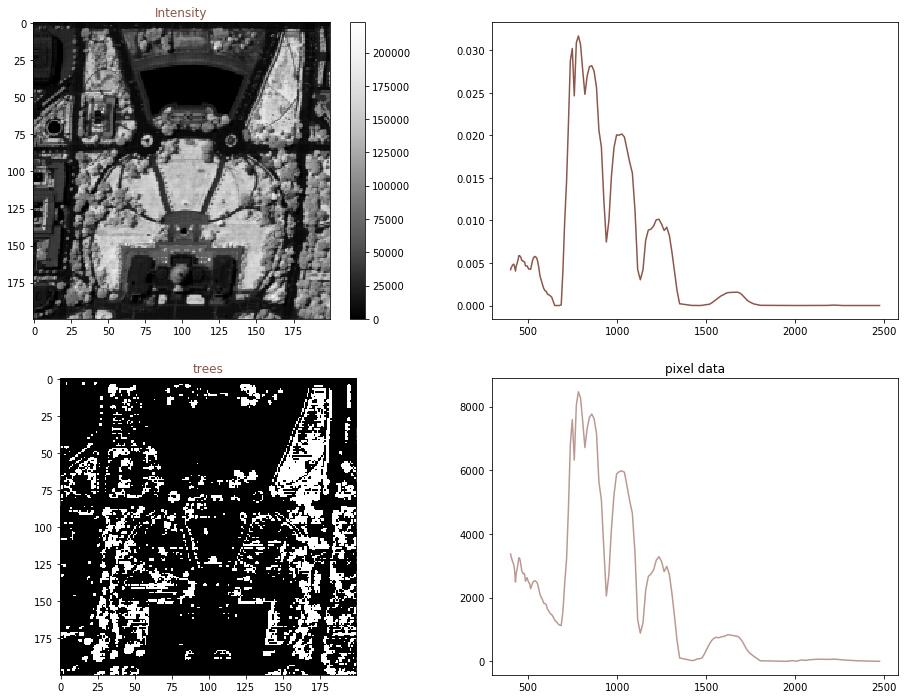

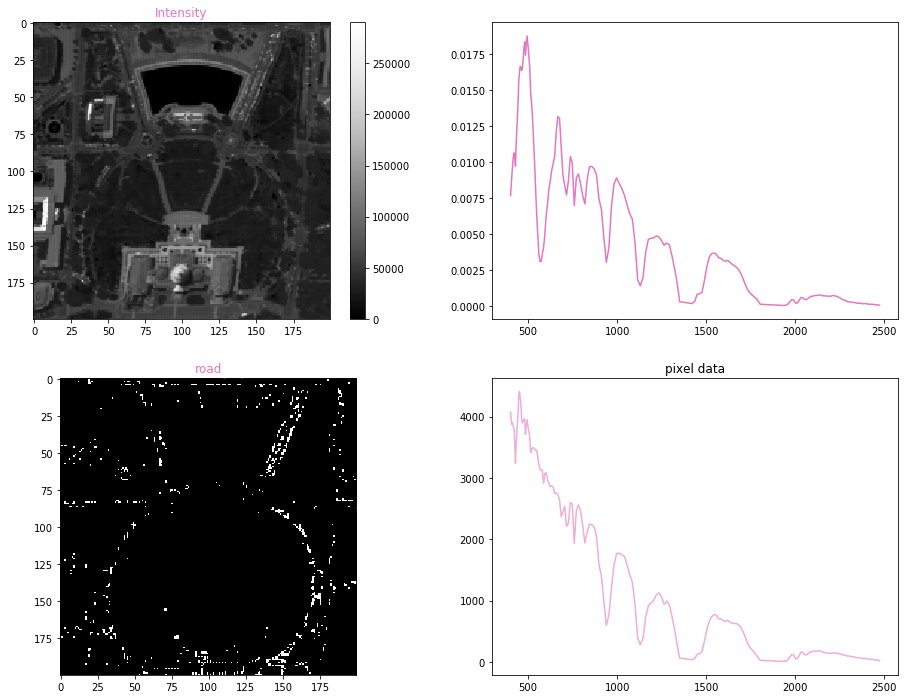

In [16]:
bkg_model = A[:,-1]*S[-1,0]
plt.plot(bkg_model)

# Only use the non-background components of A and S
Ab = A[:,:-1]
Sb = S[:-1,:]
dc.plot_spectra(wavelength, Ab, points)
dc.compare_likelihood(subset, img_shape, Sb, points, figsize=(16,6))
dc.plot_objects(subset, Ab, Sb, img_shape, points, spectra, wavelength=wavelength)

In [17]:
residual = A.dot(S)-subset

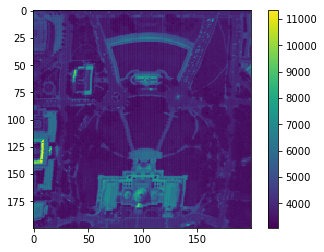

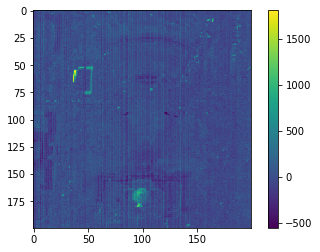

In [41]:
b = 0
plt.imshow(subset[b].reshape(img_shape))
plt.colorbar()
plt.show()
plt.imshow(residual[b].reshape(img_shape))
plt.colorbar()
plt.show()

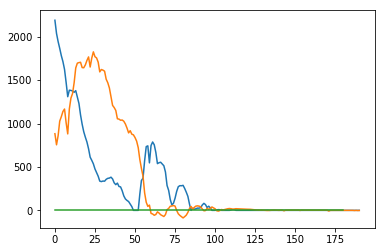

In [54]:
#plt.plot(np.min(subset, axis=1))
plt.plot(bkg_model)
plt.plot(np.min(subset, axis=1)-bkg_model)
plt.plot([0,180],[0,0])